In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys
import h5py
import json

sys.path.append(os.environ['ROOTDIR'])

from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

In [34]:
def get_cm_and_scores(path, name='model'):
    
    with open(os.path.join(path, 'conf.json')) as f:
        conf = json.load(f)
    
    df = pd.read_csv(os.path.join('..','..',conf['data'], 'objects.csv'))
    class_names = list(df['label'].values)

    with h5py.File(os.path.join(path, 'test', 'predictions.h5'), "r") as f:
        y_true = f['y_true'][()]
        y_pred = np.argmax(f['y_pred'][()], 1)
    cm  = confusion_matrix(y_true, y_pred, normalize='true')
    
    with open(os.path.join(path, 'test', 'test_results.json'), 'r') as f:
        metrics = json.load(f)
    
    metrics['title'] = name
    return metrics, cm, class_names

In [35]:
prefix = 'macho'
metrics_0, cm_0, cls_names_0 = get_cm_and_scores( "../../runs/"+prefix+"_0/", name='RNN+Att')
metrics_1, cm_1, cls_names_1 = get_cm_and_scores( "../../runs/"+prefix+"_1/", name='RNN+Lc')
metrics_2, cm_2, cls_names_2 = get_cm_and_scores( "../../runs/"+prefix+"_2/", name='FC+[CLS]-Att')

<AxesSubplot:title={'center':'FC+[CLS]-Att'}>

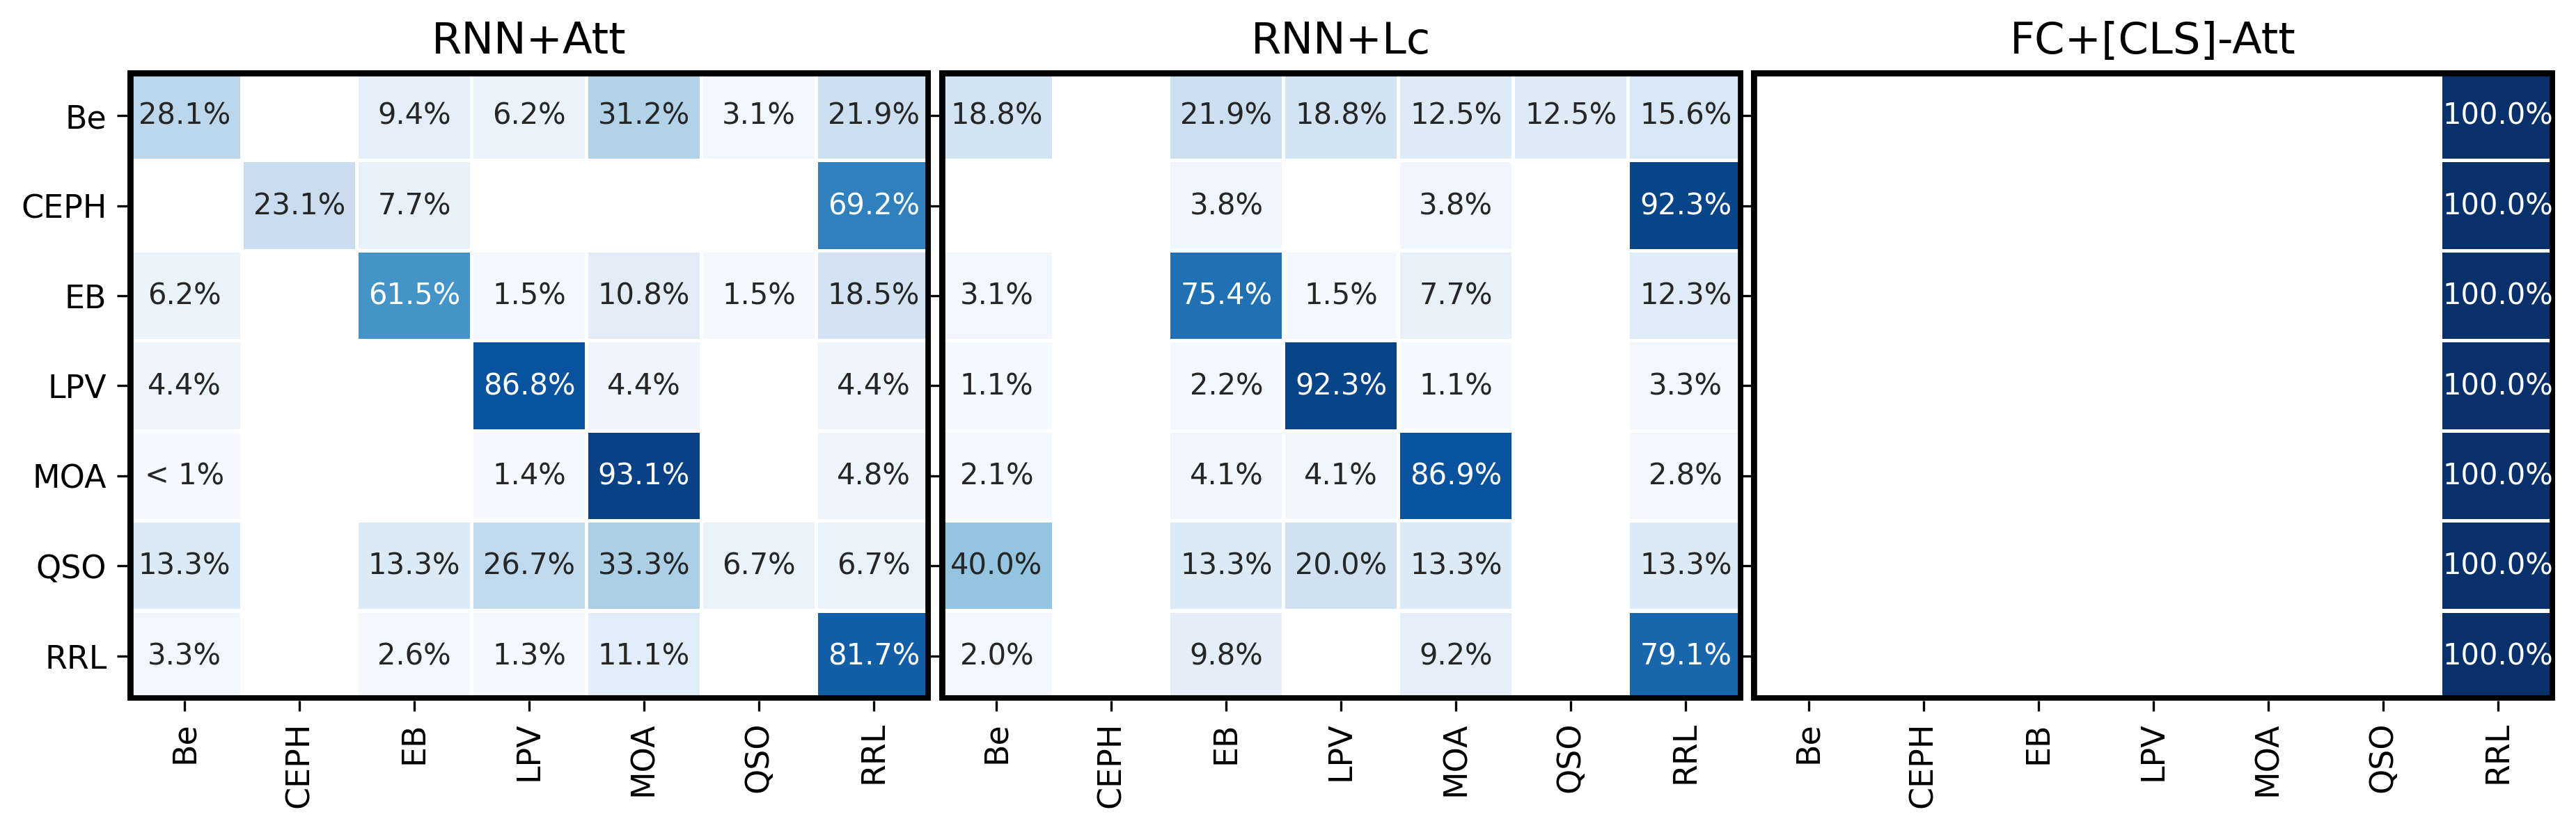

In [36]:
fig, axes = plt.subplots(1,3, figsize=(15,4), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.01}, dpi=300)

plot_cm(cm_0, axes[0], title=metrics_0['title'], class_names=cls_names_0, fontsize=10)
plot_cm(cm_1, axes[1], title=metrics_1['title'], class_names=cls_names_1, fontsize=10)
plot_cm(cm_2, axes[2], title=metrics_2['title'], class_names=cls_names_2, fontsize=10)

In [37]:
import pandas as pd

print('Model & F1 & Recall & Precision & Accuracy \\\\\hline')
for dictonary in [metrics_0,metrics_1, metrics_2]:
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\\hline '.format(dictonary['title'],
                                                          dictonary['f1'],
                                                          dictonary['recall'],
                                                          dictonary['precision'],
                                                          dictonary['accuracy']))

Model & F1 & Recall & Precision & Accuracy \\\hline
RNN+Att & 0.57 & 0.54 & 0.69 & 0.75 \\\hline 
RNN+Lc & 0.48 & 0.50 & 0.47 & 0.73 \\\hline 
FC+[CLS]-Att & 0.06 & 0.14 & 0.04 & 0.29 \\\hline 
